# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data')
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [5]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

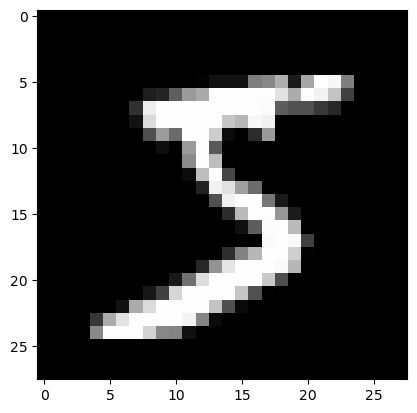

In [7]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

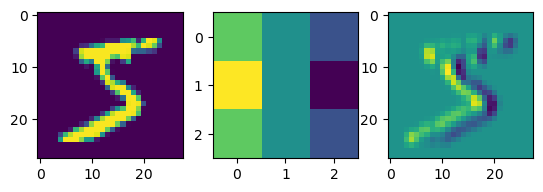

In [8]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [12]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

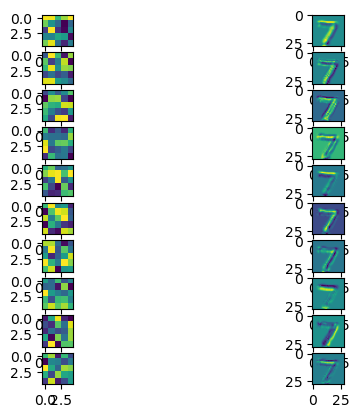

In [13]:
visualize()

# Predict Using Network

In [14]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([4, 3, 4, 1, 1])

# First Test and Train

In [18]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [20]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [21]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.292782
Train loss: 1.856362
Train loss: 1.091829
Train loss: 0.932446
Train loss: 0.691821
Train loss: 0.695408
Train loss: 0.380433
Train loss: 0.667380
Train loss: 0.423076
Train loss: 0.461933


# Train Network

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.312752
Train loss: 1.952545
Train loss: 1.211816
Train loss: 1.123573
Train loss: 0.755121
Train loss: 0.802096
Train loss: 0.556275
Train loss: 0.727390
Train loss: 0.493400
Train loss: 0.508442
Test accuracy: 94%

Train loss: 0.490811
Train loss: 0.410064
Train loss: 0.324191
Train loss: 0.578655
Train loss: 0.424027
Train loss: 0.429618
Train loss: 0.278704
Train loss: 0.477417
Train loss: 0.443268
Train loss: 0.358389
Test accuracy: 96%

Train loss: 0.367950
Train loss: 0.304900
Train loss: 0.232849
Train loss: 0.377858
Train loss: 0.276920
Train loss: 0.167548
Train loss: 0.268284
Train loss: 0.395174
Train loss: 0.380286
Train loss: 0.392494
Test accuracy: 97%

Train loss: 0.193646
Train loss: 0.249019
Train loss: 0.158599
Train loss: 0.343523
Train loss: 0.129930
Train loss: 0.159150
Train loss: 0.206561
Train loss: 0.295107
Train loss: 0.580966
Train loss: 0.414687
Test accuracy: 97%

Train loss: 0.178054
Train loss: 0.163568
Train loss: 0.161558
Train loss: 0.376

# Inspect Network

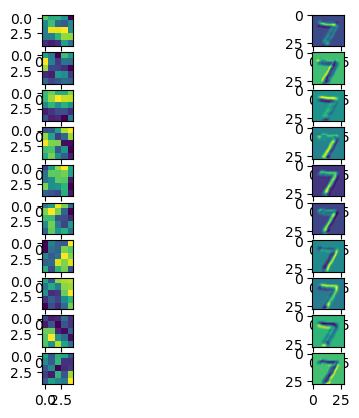

In [23]:
visualize()

In [24]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [25]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [26]:
torch.manual_seed(1234)

# 60, 000 images

- Accuracy about 98%

In [27]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [28]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.305154
Train loss: 2.061901
Train loss: 1.036981
Train loss: 0.890878
Train loss: 0.734189
Train loss: 0.530296
Train loss: 0.498253
Train loss: 0.513013
Train loss: 0.575955
Train loss: 0.596223
Test accuracy: 94%

Train loss: 0.387874
Train loss: 0.480744
Train loss: 0.463416
Train loss: 0.561570
Train loss: 0.263154
Train loss: 0.404543
Train loss: 0.384727
Train loss: 0.319425
Train loss: 0.363749
Train loss: 0.326239
Test accuracy: 96%

Train loss: 0.248081
Train loss: 0.501966
Train loss: 0.242186
Train loss: 0.614002
Train loss: 0.207705
Train loss: 0.333806
Train loss: 0.350595
Train loss: 0.547232
Train loss: 0.221701
Train loss: 0.620054
Test accuracy: 97%

Train loss: 0.211577
Train loss: 0.384170
Train loss: 0.168794
Train loss: 0.433240
Train loss: 0.119668
Train loss: 0.365084
Train loss: 0.233283
Train loss: 0.277907
Train loss: 0.480044
Train loss: 0.402278
Test accuracy: 97%

Train loss: 0.139929
Train loss: 0.277603
Train loss: 0.141163
Train loss: 0.307

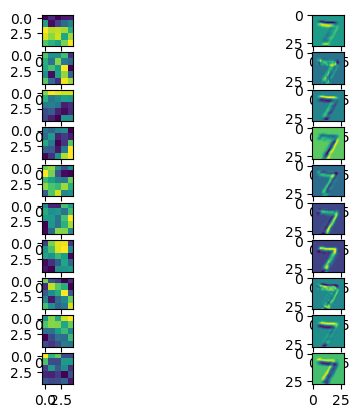

In [29]:
visualize()

# 30,000 images

- Accuracy about 97%

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [32]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.291339
Train loss: 1.893080
Train loss: 1.002853
Train loss: 0.831568
Train loss: 0.665758
Test accuracy: 91%

Train loss: 0.593637
Train loss: 0.437431
Train loss: 0.492578
Train loss: 0.447545
Train loss: 0.385379
Test accuracy: 95%

Train loss: 0.480643
Train loss: 0.384617
Train loss: 0.319308
Train loss: 0.378473
Train loss: 0.383261
Test accuracy: 96%

Train loss: 0.323886
Train loss: 0.194686
Train loss: 0.246740
Train loss: 0.313670
Train loss: 0.325552
Test accuracy: 97%

Train loss: 0.338507
Train loss: 0.176876
Train loss: 0.255992
Train loss: 0.349985
Train loss: 0.186937
Test accuracy: 97%



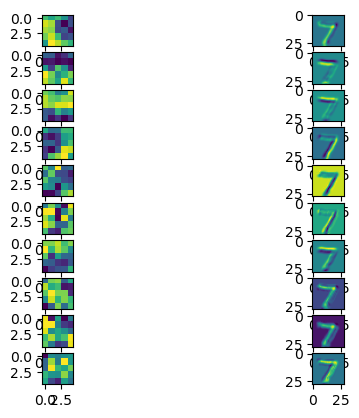

In [33]:
visualize()

# 6,000 images

- Accuracy about 92%

In [34]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [35]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.302813
Test accuracy: 50%

Train loss: 2.186715
Test accuracy: 79%

Train loss: 1.222540
Test accuracy: 88%

Train loss: 1.002545
Test accuracy: 91%

Train loss: 0.840463
Test accuracy: 92%



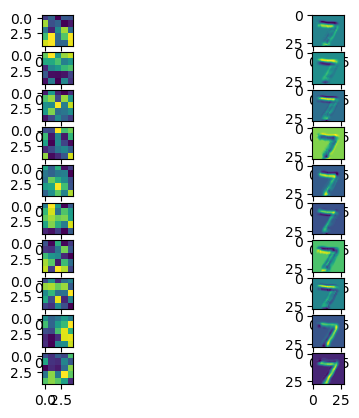

In [37]:
visualize()

# 3,000 images

- Accuracy about 85%

In [38]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [39]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.319998
Test accuracy: 46%

Train loss: 2.291130
Test accuracy: 63%

Train loss: 1.960249
Test accuracy: 71%

Train loss: 1.715094
Test accuracy: 80%

Train loss: 1.309780
Test accuracy: 85%



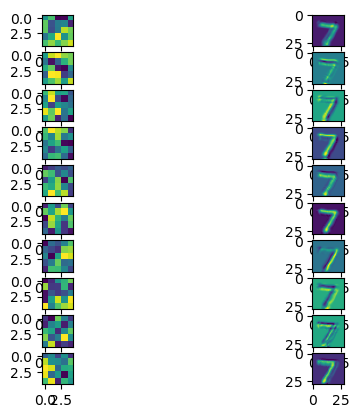

In [40]:
visualize()

# 600 images

- Accuracy about 24%

In [41]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [42]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_31483/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.307698
Test accuracy: 13%

Train loss: 2.306119
Test accuracy: 16%

Train loss: 2.306432
Test accuracy: 18%

Train loss: 2.274593
Test accuracy: 24%

Train loss: 2.271937
Test accuracy: 24%



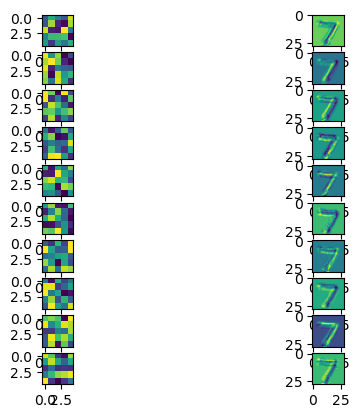

In [43]:
visualize()

# Exercise 1b 

- Compared to the weights trained with 60,000 and 600, we can immediately tell that the weights are clustered after training in 60,000 images while the weights are still quite spread out in the 600 images training. 